# Comparison of track parameter in full and fast simulation

I want to plot the 5 track parameters and the 15 covariance parameters for $H \rightarrow u \bar{u}$ for the leading tracks in fast and full simulation. Therefore, I need to make sure to plot the same track params and especially find out what the 15 covariance parameters mean.

In [4]:
import uproot 
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator, FuncFormatter

import gc

from sklearn.metrics import roc_curve, auc, roc_auc_score
from matplotlib.lines import Line2D

%load_ext autoreload
%autoreload 2

In [38]:
from cycler import cycler
import matplotlib

# Set the color cycle
# https://coolors.co/542344-f68e5f-e5e059-007ea7-98e2c6
plt.rc('axes', prop_cycle=cycler('color', ['#73b06f', '#e6701b', '#007090', '#e7298a', '#802392', '#ffad08', '#56b4e9']))
matplotlib.rcParams["font.family"] = "serif"

In [1]:
path_fullsim = "/eos/experiment/fcc/ee/datasets/CLD_fullsim_tagging_input/hadded/Huu.root"
path_fastsim = "/eos/experiment/fcc/ee/jet_flavour_tagging/winter2023/fastsim_2mio_total_SaraTagging/CLD/training/Huu.root"

In [5]:
def load_data(file_name, stop=25000):
    file = uproot.open(file_name)
    tree = file['tree;1']
    data = tree.arrays(library="np", entry_start=0, entry_stop=stop)
    return data

In [6]:
dic = {"full": load_data(path_fullsim), "fast": load_data(path_fastsim)}

First, let's get the leading tracks.

In [11]:
def get_index_charged_particles(df, ptype='cpart'):
    """Choose particle type: cpart, npart, photon"""
    if df == 'fast':
        types = dic[df]['pfcand_type']
        if ptype=='cpart':
            num = [0]
        elif ptype=='npart':
            num = [130]
        elif ptype=='photon':
            num = [22]
    elif df == 'full':
        types = dic[df]['pfcand_type']
        if ptype=='cpart':
            num = [-211, -13, -11, 11, 13, 211] 
        elif ptype=='npart':
            num = [2112]
        elif ptype=='photon':
            num = [22]
    mask_bool_chad = []
    for i in range(types.shape[0]):
        index = np.where(np.isin(types[i], num))[0]
        bool_list = np.zeros(len(types[i]), dtype=bool)
        bool_list[index] = True
        mask_bool_chad.append(bool_list)
    return mask_bool_chad

In [16]:
def get_value_highest_energy_particle(df, k=3, ptype='cpart', debug=False):
    """return the index of the k highest energy charged particle in each event"""
    if df == 'fast':
        particles_e = dic[df]['pfcand_e']
        mask_chad = get_index_charged_particles('fast', ptype=ptype)
    elif df == 'full':
        particles_e = dic[df]['pfcand_e']
        mask_chad = get_index_charged_particles('full', ptype=ptype)
    index_charged = []
    for i  in range(particles_e.shape[0]):
        part_e = particles_e[i]
        ind = np.argsort(part_e)[::-1]
        mask = mask_chad[i]
        c_index = np.arange(len(part_e))[mask] # indicies with charged/neutral particles
        # now order the charged/neutral particles by energy with ind
        index_map = {value: np.where(ind == value)[0][0] for value in c_index}
        sorted_c_index = sorted(c_index, key=lambda x: index_map[x])
        index_charged.append(sorted_c_index[:k])
        if debug and i==1:
            print("part_e: ", part_e)
            print("mask: ", mask)
            print("ind: ", ind)
            print("index_map: ", index_map)
            print("c_index: ", c_index)
            print("sorted_c_index: ", sorted_c_index)
    return index_charged

In [17]:
def get_chad_elements(df_value, index):
    e_1 = []
    e_2 = []
    e_3 = []
    for i in range(len(df_value)):
        index_list = index[i] # this can have 1, 2 or 3 elements
        if len(index_list) == 1:
            e_1.append(df_value[i][index_list[0]])
        elif len(index_list) == 2:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
        elif len(index_list) == 3:
            e_1.append(df_value[i][index_list[0]])
            e_2.append(df_value[i][index_list[1]])
            e_3.append(df_value[i][index_list[2]])
    return [np.array(e_1), np.array(e_2), np.array(e_3)]

In [18]:
index_charged_3E_full = get_value_highest_energy_particle("full")
index_charged_3E_fast = get_value_highest_energy_particle("fast")

Now we can get any variable `key` with `myvar = get_chad_elements(dic["fast"][key], index_charged_3E_fast)`. 

## Helix track parameters

I want to use the full sim convension and use $\vec \alpha = (d_0, \phi, c, z_0, \tan \lambda)$ to describe a helix track. Let's see how we can retrieve these variables. 
- $d_0$: that's `pfcand_dxy`
- $\phi$: that's `pfcand_phi`
- $c$: well, that should be $c = \frac{a}{2 \cdot p_t}$ with $a = -q \cdot B_z \cdot v_\mathrm{light}$. We can get $p_t = \sin{\theta} \cdot |p|$. So all in all, it's $c = \frac{-q \cdot B_z \cdot v_\mathrm{light}}{2 \cdot \sin{\theta} \cdot |p|}$
- $z_0$: that's `pfcand_dz`
- $\tan \lambda$: This is $\tan \lambda = \frac{p_z}{p_t} = \frac{\cos{\theta} \cdot |p|}{\sin{\theta} \cdot |p|} = \cot{\theta}$. We use `pfcand_theta` and calculate $\cot{\theta} = 1/ \tan{\theta}$. 

In [19]:
def get_5_track_params(data, index_charged):
    """ Get the 5 track parameters for the highest energy charged particle"""
    d0 = get_chad_elements(data['pfcand_dxy'], index_charged)[0]
    z0 = get_chad_elements(data['pfcand_dz'], index_charged)[0]
    phi = get_chad_elements(data['pfcand_phi'], index_charged)[0]
    theta = get_chad_elements(data['pfcand_theta'], index_charged)[0]
    q = get_chad_elements(data['pfcand_charge'], index_charged)[0]
    p = get_chad_elements(data['pfcand_p'], index_charged)[0]

    Bz = 2.0
    c_light = 2.99792458e8 * 1.0e-9 # from fast sim ... https://github.com/HEP-FCC/FCCAnalyses/blob/63d346103159c4fc88cdee7884e09b3966cfeca4/analyzers/dataframe/src/ReconstructedParticle2Track.cc#L113 

    # calculate the curvature
    c = - q * Bz * c_light / (2 * np.sin(theta) * p)
    tanlam = 1 / np.tan(theta)

    return d0, phi, c, z0, tanlam


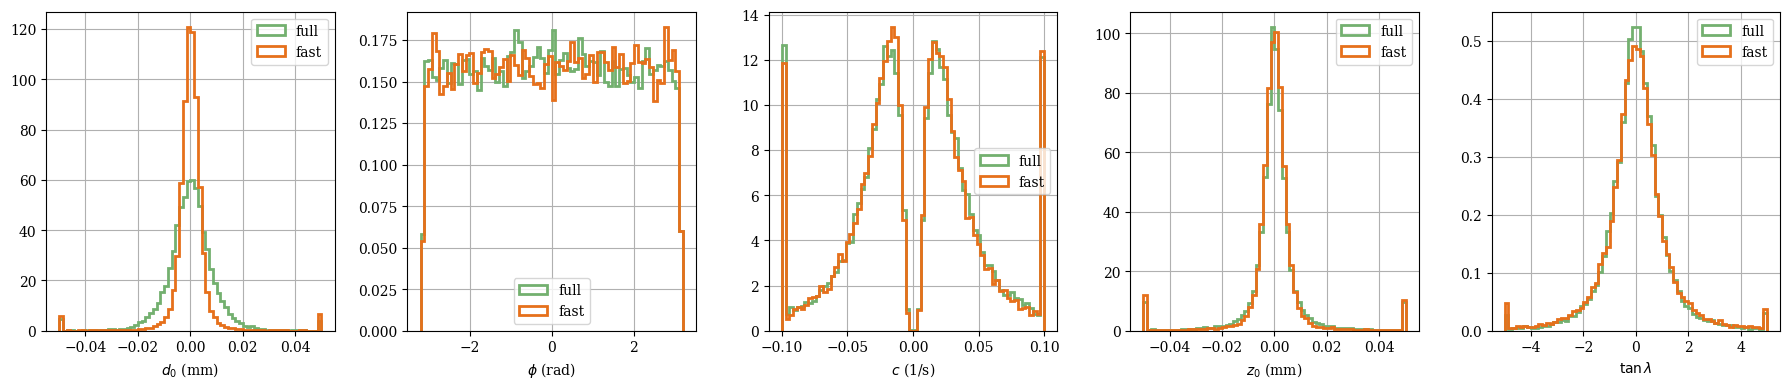

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(18, 4))
labels = [r"$d_0$ (mm)", r"$\phi$ (rad)", "$c$ (1/s)", "$z_0$ (mm)", r"$\tan{\lambda}$"]
ranges = [(-0.05, 0.05), (-3.2, 3.2), (-0.1, 0.1), (-0.05, 0.05), (-5.0, 5.0)]
bins = 70
for k in dic.keys():
    if k == "full":
        d0, phi, c, z0, tanlam = get_5_track_params(dic[k], index_charged_3E_full)
    elif k == "fast":
        d0, phi, c, z0, tanlam = get_5_track_params(dic[k], index_charged_3E_fast)
    else:
        raise ValueError("Wrong key") 

    # overflow and underflow bins
    d0 = np.clip(d0, ranges[0][0], ranges[0][1])
    c = np.clip(c, ranges[2][0], ranges[2][1])
    z0 = np.clip(z0, ranges[3][0], ranges[3][1])
    tanlam = np.clip(tanlam, ranges[4][0], ranges[4][1])

    # plot the 5 track parameters
    axs = axs.ravel()
    for i, ax in enumerate(axs):
        # plot the histograms
        ax.hist([d0, phi, c, z0, tanlam][i], bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=ranges[i])
        ax.set_xlabel(labels[i])
        ax.legend()
        ax.grid(True)
plt.tight_layout()
plt.show()


## Covariance parameters

Now let's have a look at the cov matrix elements. As I just retrieve them straight forward from fast and full sim, it is important to understand what these refer to _exactely_. 

**Full sim**: 
- [Here](https://github.com/key4hep/EDM4hep/blob/997ab32b886899253c9bc61adea9a21b57bc5a21/edm4hep.yaml#L195C9-L200) is the documentation. 
- They use the same track parameters as I do, apart from $c$ as they use $\omega$ instead. While $c$ has units of $1/s$, $\omega$ has $1/mm$. 

**Fast sim**: 
This will get tidious, as I need to dig really deep to find this out. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/addons/ONNXRuntime/python/jetFlavourHelper.py#L131), the variables are retrieved from C++ to python. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/JetConstituentsUtils.cc#L303) is the C++ definition. 
- [Here](https://github.com/HEP-FCC/FCCAnalyses/blob/pre-edm4hep1/analyzers/dataframe/src/ReconstructedParticle2Track.cc#L415) is the cov Matrix accessed. 
- [Here](https://github.com/key4hep/k4SimDelphes/blob/main/converter/src/DelphesEDM4HepConverter.cc#L573) is the covMatrix definied using a conversion from code from FB. 

Now it get's interesting. Here we see the definition of $\omega$ using $c$: 

```
// relating to curvature (index 2)
double scale2 = -2.;  // CAREFUL: DELPHES USES THE HALF-CURVATURE
trackState.omega = cand->C * scale2;
```

But this at least means, that everything in fast sim should be the same as in full sim / key4hep! Also the file is called DelphesEDM4HepConverter.cc which is promissing. 
- Because we see [here](https://github.com/key4hep/k4SimDelphes/blob/main/converter/src/DelphesEDM4HepConverter.cc#L539-L562) that **the same helix parametrization** is used!!
- Again, [here](https://github.com/delphes/delphes/blob/master/modules/TrackCovariance.cc#L173) we see the same definition of track params. 
- [Here](https://github.com/delphes/delphes/blob/2f87c5edc29159cb335ea2cda77b70dca5d94c50/external/TrackCovariance/TrkUtil.cc#L304-L316), we see the conversion that is used... e.g. from omega to c: it seems to be a factor of -2 plus units. 


*Discrepencies in cov*: 

- cov(c, d0): values differ a bit
- cov(c,  phi): values differ a bit
- cov(c, tanlam): sign: fast only >0
- cov(c, z0): sign, fast only <0
- cov(phi, tanlam): sign, fast only>0
- cov(phi, z0): sing, fast only<0
- cov(d0, tanlam): sign, fast only < 0
- cov(d0, z0): sign, fast only>0

What can we **conclude**? 

- I am confused about cov(d0, z0) - why is this in fast sim only positive and not symmetric around 0? As d0 and z0 are symmetric around 0?


In [86]:
keys = [
'pfcand_cctgtheta',
'pfcand_cdz',
'pfcand_detadeta',
'pfcand_dlambdadz',
'pfcand_phic',
'pfcand_phictgtheta',
'pfcand_phidz',
'pfcand_dphidphi',
'pfcand_dphidxy',
'pfcand_dptdpt',
'pfcand_dxyc',
'pfcand_dxyctgtheta',
'pfcand_dxydxy',
'pfcand_dxydz',
'pfcand_dzdz']

xlabels = {
    'pfcand_cctgtheta': r"cov($c$, $\tan{\lambda}$)",
    'pfcand_cdz': r"cov($c$, $z_0$)",
    'pfcand_detadeta': r"cov($\tan{\lambda}$, $\tan{\lambda}$)",
    'pfcand_dlambdadz': r"cov($\tan{\lambda}$, $z_0$)",
    'pfcand_phic': r"cov($\phi$, $c$)",
    'pfcand_phictgtheta': r"cov($\phi$, $\tan{\lambda}$)",
    'pfcand_phidz': r"cov($\phi$, $z_0$)",
    'pfcand_dphidphi': r"cov($\phi$, $\phi$)",
    'pfcand_dphidxy': r"cov($\phi$, $d_0$)",
    'pfcand_dptdpt': r"cov($c$, $c$)",
    'pfcand_dxyc': r"cov($d_0$, $c$)",
    'pfcand_dxyctgtheta': r"cov($d_0$, $\tan{\lambda}$)",
    'pfcand_dxydxy': r"cov($d_0$, $d_0$)",
    'pfcand_dxydz': r"cov($d_0$, $z_0$)",
    'pfcand_dzdz': r"cov($z_0$, $z_0$)",
}

r = {
    'pfcand_cctgtheta': [-1e-11, 1e-11],
    'pfcand_cdz': [-2e-10, 2e-10],
    'pfcand_detadeta': [0, 0.5e-6],
    'pfcand_dlambdadz': [-0.5e-5, 0],
    'pfcand_phic': [0, 0.2e-10],
    'pfcand_phictgtheta': [-0.2e-08, 0.2e-08], 
    'pfcand_phidz': [-0.05e-6, 0.05e-6],
    'pfcand_dphidphi': [0.0, 0.3e-6], 
    'pfcand_dphidxy': [-0.3e-5, 0],
    'pfcand_dptdpt': [0, 5e-13], #[0, 0.5e-13], 
    'pfcand_dxyc': [-0.25e-9, 0.25e-9],
    'pfcand_dxyctgtheta': [-0.1e-6, 0.1e-6], 
    'pfcand_dxydxy': [0, 1.0e-4],
    'pfcand_dxydz': [-0.25e-5, 0.25e-5], # here
    'pfcand_dzdz': [0, 1.0e-4],
}

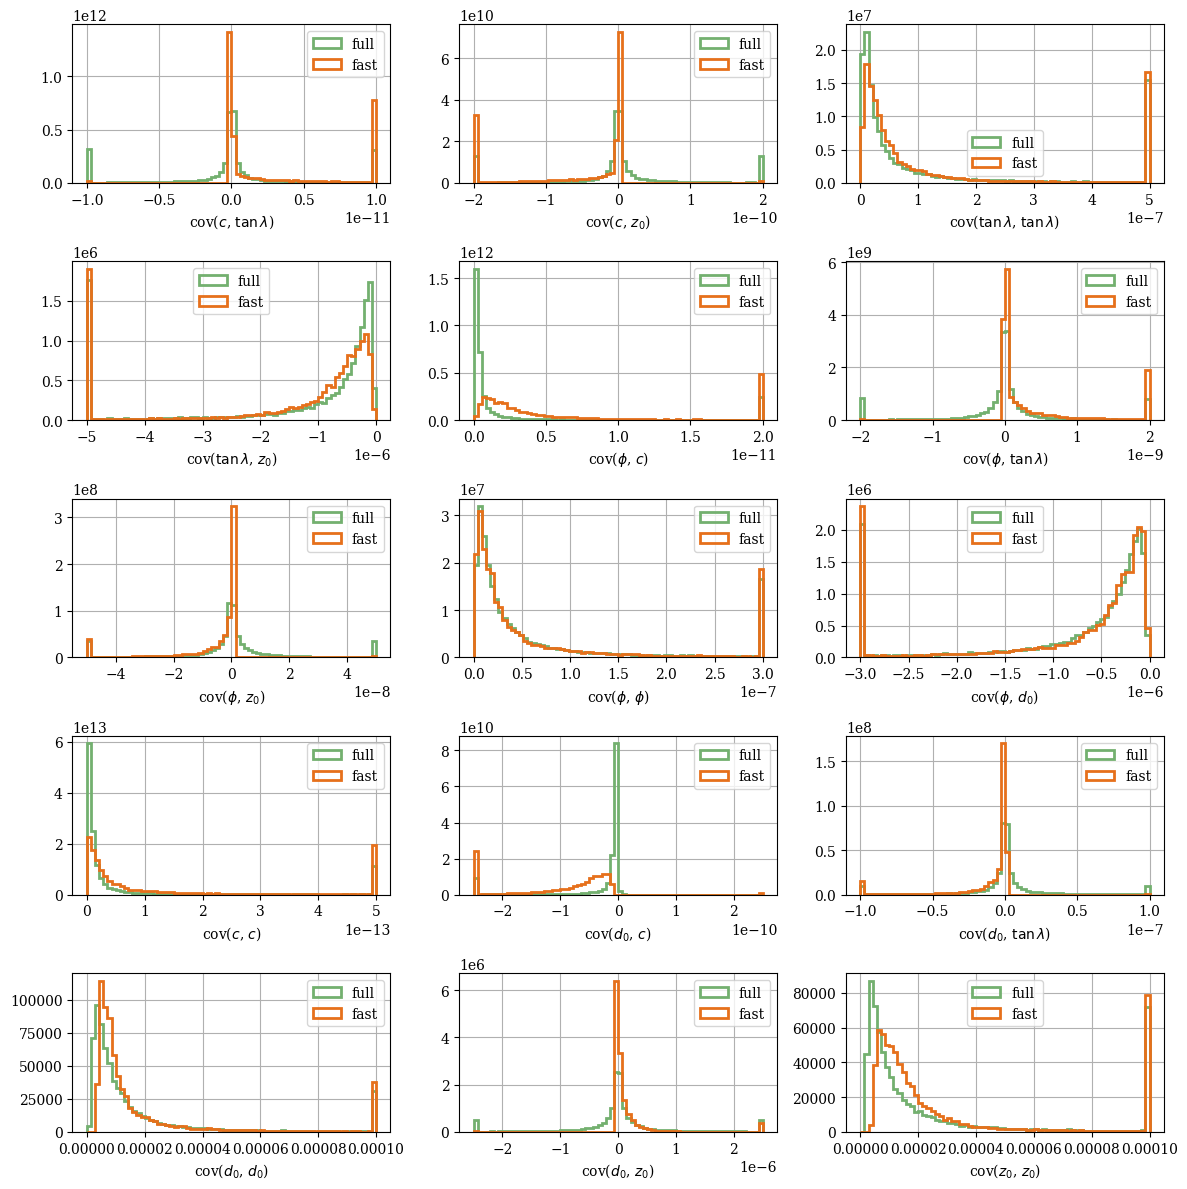

In [87]:
fig, axs = plt.subplots(5, 3, figsize=(12, 12))
bins = 70
for k in dic.keys():
    for i, key in enumerate(keys):
        if k == "full":
            d = get_chad_elements(dic[k][key], index_charged_3E_full)[0]
        elif k == "fast":
             d = get_chad_elements(dic[k][key], index_charged_3E_fast)[0]
        else:
            raise ValueError("Wrong key") 
        d = np.clip(d, r[key][0], r[key][1])
        ax = axs.ravel()
        ax[i].hist(d, bins=bins, histtype='step', label=k, density=True, linewidth=2.0, range=r[key])
        ax[i].set_xlabel(xlabels[key])
        ax[i].legend()
        ax[i].grid(True)
plt.tight_layout()
plt.show()